# Import

In [1]:
# Misc
import os
import json
import joblib
import warnings
from ipywidgets import IntProgress
from IPython.display import display

# Data management
import numpy as np
import pandas as pd

# Sound treatments
import librosa

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Environment

In [2]:
# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

In [3]:
DATA_PATH = './data/'
WORKING_PATH = './working/final/'

# Data exploration

## Data load

In [4]:
# Load meta data
train_meta = pd.read_csv(DATA_PATH + 'train_metadata.csv',
                         sep=',', decimal='.', encoding='utf8', low_memory=False)

In [5]:
train_meta.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [6]:
# Load scored birds
with open(DATA_PATH + 'scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)

scored_birds

['akiapo',
 'aniani',
 'apapan',
 'barpet',
 'crehon',
 'elepai',
 'ercfra',
 'hawama',
 'hawcre',
 'hawgoo',
 'hawhaw',
 'hawpet1',
 'houfin',
 'iiwi',
 'jabwar',
 'maupar',
 'omao',
 'puaioh',
 'skylar',
 'warwhe1',
 'yefcan']

## Distribution per class

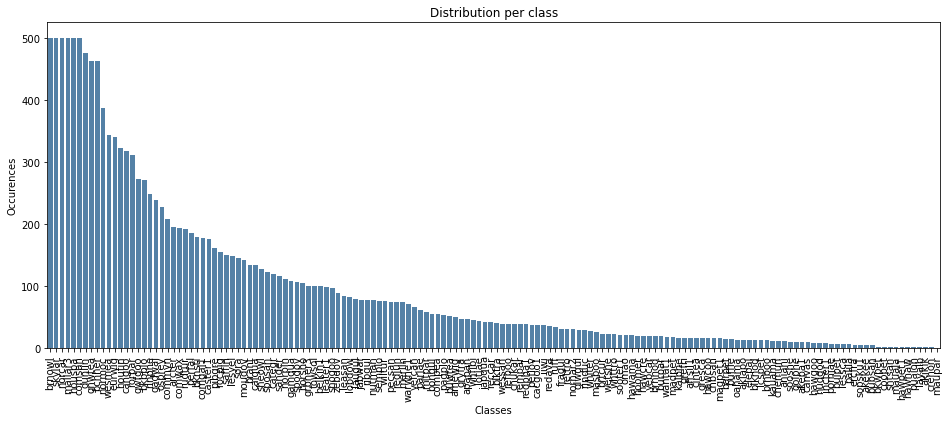

In [7]:
birds = train_meta["primary_label"].value_counts().to_dict()

fig = plt.figure(figsize=(16, 6))
sns.barplot(x=list(birds.keys()), y=list(birds.values()), color='steelblue')
plt.title('Distribution per class')
plt.xlabel('Classes')
plt.ylabel('Occurences')
plt.xticks(rotation=90)
plt.show()

In [8]:
key_max = max(birds.keys(), key=(lambda k: birds[k]))
key_min = min(birds.keys(), key=(lambda k: birds[k]))

print('Number of classes: ', len(birds.keys()))
print('')
print('Minimum number of sounds for the class: ',
      key_min + ' ' + str(birds[key_min]))
print('Maximum number of sounds for the class: ',
      key_max + ' ' + str(birds[key_max]))
print('Total number of sounds: ', sum(birds.values()))
print('Average number of sounds per classes: ',
      sum(birds.values()) / len(birds.values()))

Number of classes:  152

Minimum number of sounds for the class:  maupar 1
Maximum number of sounds for the class:  brnowl 500
Total number of sounds:  14852
Average number of sounds per classes:  97.71052631578948


## Focus on scored birds

In [9]:
# Focus on 21 scored classes
data_filtered = train_meta[train_meta['primary_label'].isin(scored_birds)]

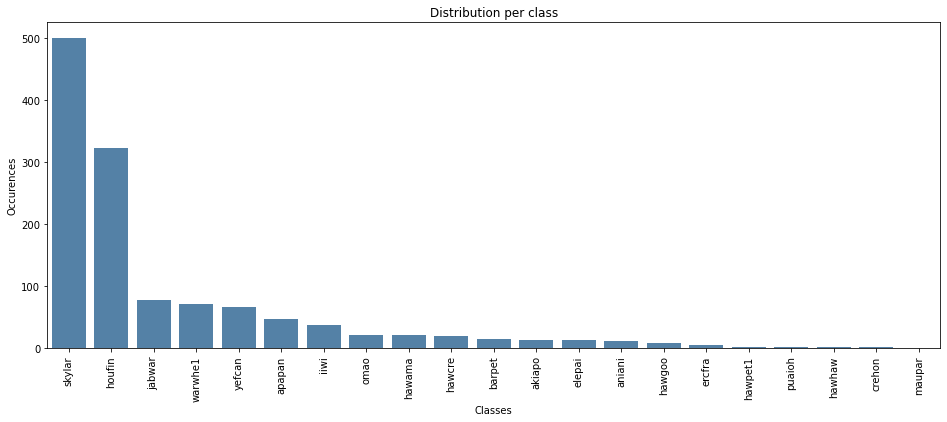

In [10]:
birds_filtered = data_filtered['primary_label'].value_counts().to_dict()

fig = plt.figure(figsize=(16, 6))
sns.barplot(x=list(birds_filtered.keys()), y=list(
    birds_filtered.values()), color='steelblue')
plt.title('Distribution per class')
plt.xlabel('Classes')
plt.ylabel('Occurences')
plt.xticks(rotation=90)
plt.show()

In [11]:
key_max = max(birds_filtered.keys(), key=(lambda k: birds_filtered[k]))
key_min = min(birds_filtered.keys(), key=(lambda k: birds_filtered[k]))

print('Number of classes: ', len(birds_filtered.keys()))
print('Missing classes: ', scored_birds-birds_filtered.keys())
print('')
print('Minimum number of sounds for the class: ',
      key_min + ' ' + str(birds_filtered[key_min]))
print('Maximum number of sounds for the class: ',
      key_max + ' ' + str(birds_filtered[key_max]))
print('Total number of sounds: ', sum(birds_filtered.values()))
print('Average number of sounds per classes: ', sum(
    birds_filtered.values()) / len(birds_filtered.values()))

Number of classes:  21
Missing classes:  set()

Minimum number of sounds for the class:  maupar 1
Maximum number of sounds for the class:  skylar 500
Total number of sounds:  1266
Average number of sounds per classes:  60.285714285714285


## Birds number per sound

In [12]:
# Split secondary_labels in a list of birds
def split_secondary(df):
    record = df['secondary_labels'].replace(
        '[', '').replace(']', '').replace("'", "").split(',')
    return record


data_filtered['secondary_list'] = data_filtered.apply(split_secondary, axis=1)

C:\Users\james\AppData\Local\Temp\ipykernel_2972\1351192593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['secondary_list'] = data_filtered.apply(split_secondary, axis=1)


In [13]:
# Count the birds in the birds lists
def birds_number(df):
    return len(df['secondary_list'])


data_filtered['birds_number'] = data_filtered.apply(birds_number, axis=1)

C:\Users\james\AppData\Local\Temp\ipykernel_2972\1689811102.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['birds_number'] = data_filtered.apply(birds_number, axis=1)


In [14]:
data_filtered['secondary_list'] = data_filtered.apply(split_secondary, axis=1)
data_filtered['birds_number'] = data_filtered.apply(birds_number, axis=1)

C:\Users\james\AppData\Local\Temp\ipykernel_2972\3902746202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['secondary_list'] = data_filtered.apply(split_secondary, axis=1)
C:\Users\james\AppData\Local\Temp\ipykernel_2972\3902746202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['birds_number'] = data_filtered.apply(birds_number, axis=1)


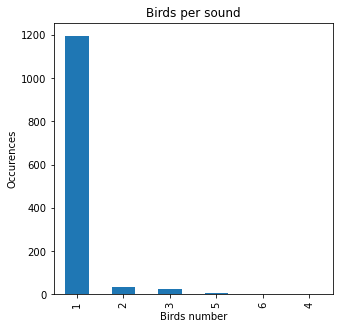

In [15]:
fig = plt.figure(figsize=(5, 5))
data_filtered['birds_number'].value_counts().plot(kind='bar')
plt.title('Birds per sound')
plt.xlabel('Birds number')
plt.ylabel('Occurences')
plt.show()

In [16]:
data_filtered['birds_number'].value_counts()

1    1197
2      35
3      23
5       5
6       3
4       3
Name: birds_number, dtype: int64

## Misc

In [17]:
data_filtered['primary_label'].value_counts()

skylar     500
houfin     322
jabwar      78
warwhe1     71
yefcan      67
apapan      47
iiwi        37
omao        21
hawama      21
hawcre      20
barpet      15
akiapo      14
elepai      14
aniani      12
hawgoo       9
ercfra       6
hawpet1      3
puaioh       3
hawhaw       3
crehon       2
maupar       1
Name: primary_label, dtype: int64

In [18]:
data_filtered.shape

(1266, 15)

## Sounds characteristics

In [19]:
if not os.path.exists(WORKING_PATH + 'sample_rates.jl'):
    # Instantiate the progress bar
    max_count = data_filtered.shape[0]
    f = IntProgress(min=0, max=max_count)
    # Display the progress bar
    display(f)

    sample_rates = {}
    durations = []

    for index, row in data_filtered.iterrows():
        # Increment the progress bar
        f.value += 1

        # Load sound
        file_path = DATA_PATH + 'train_audio/' + row['filename']
        audio, sr = librosa.load(file_path)

        # Calculate duration
        duration = len(audio)/sr

        # Store
        if sr in sample_rates.keys():
            sample_rates[sr] += 1
        else:
            sample_rates[sr] = 1

        durations.append(duration)

    # Save
    joblib.dump(sample_rates, WORKING_PATH + 'sample_rates.jl')
    joblib.dump(durations, WORKING_PATH + 'durations.jl')

else:
    sample_rates = joblib.load(WORKING_PATH + 'sample_rates.jl')
    durations = joblib.load(WORKING_PATH + 'durations.jl')

In [20]:
print('Audios sample rates:', sample_rates)

Audios sample rates: {22050: 1266}


In [21]:
durations = np.array(durations)
print('Audios minimum duration:', np.min(durations))
print('Audios maximum duration:', np.max(durations))
print('Audios average duration:', np.mean(durations))

Audios minimum duration: 1.1160090702947847
Audios maximum duration: 996.9840362811791
Audios average duration: 53.04552557199815


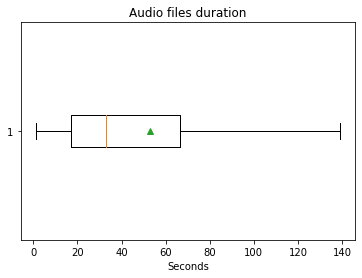

In [22]:
plt.boxplot(durations, vert=False, showmeans=True, showfliers=False)
plt.title('Audio files duration')
plt.xlabel('Seconds')
plt.show()

In [23]:
np.quantile(durations, 0.75, axis=0)

66.32963718820862

In [24]:
np.mean(durations)

53.04552557199815

## Conclusion

- 1266 audio files available for 21 classes
- Imbalanced data
- Most of the time, a sound contains 1 classe but sometimes more (multilabel)
- Sample rate 22050
- Sounds average duration is 50.42 seconds